# Avalição e parametrização

In [148]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, homogeneity_completeness_v_measure
from sklearn.metrics import matthews_corrcoef, f1_score, fbeta_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import norm # type: ignore
import warnings
warnings.filterwarnings('ignore')

In [149]:
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack((data, np.asarray(row).astype(float))) # type: ignore
            except:
                data = np.asarray(row).astype(float)
    f.close()
    y = data[:,0] # type: ignore
    x = data[:,1:] # type: ignore
    return y,x

In [150]:
def compute_kappa_varkappa(matConf):
    total = float(sum(sum(matConf))) # type: ignore
    c = len(matConf[0])
    diag = float(sum(matConf.diagonal()))
    acGlobal = float(diag/total)
    
    marg = 0.0
    for i in range(0,c):
        marg += sum(matConf[i,:])*sum(matConf[:,i])
    
    #Coeficiente kappa
    kappa = (total*diag - marg)/(total*total - marg)
    
    phi1 = acGlobal; phi2 = marg/((total)**2)
    phi3 = 0.0; phi4 = 0.0
    for i in range(0,c):
        phi3 += matConf[i,i]*(sum(matConf[i,:])+sum(matConf[:,i]))
    for i in range(0,c):
        for j in range(0,c):
            phi4 += matConf[i,j]*((sum(matConf[j,:])+sum(matConf[:,i]))**2)
    
    phi3 = phi3/((total)**2)
    phi4 = phi4/((total)**3)
    
    #Variância do coeficiente kappa
    vkappa = (1/total)*( ((phi1*(1-phi1))/((1-phi2)**2)) + 
             ((2*(1-phi1)*(2*phi1*phi2-phi3))/((1-phi2)**3)) + 
             ((((1-phi1)**2)*(phi4-4*(phi2**2)))/((1-phi2)**4)) )

    return kappa,vkappa

In [151]:
def compute_tau_varkappa(matConf):
    total = float(sum(sum(matConf))) # type: ignore
    c = len(matConf[0])
    diag = float(sum(matConf.diagonal()))
    acGlobal = float(diag/total)
    
    #Coeficiente tau e sua variância
    tau = (acGlobal - (1/c))/(1 - (1/c))
    vtau = (1/total)*((acGlobal*(1-acGlobal))/((1-(1/c))**2))
     
    return tau,vtau

## Leitura dos dados
* Os dados considerados aqui foram obtidos da USGS

* Atributos são:
    * latitude
    * longitude
    * depth
    * mag
    * gap
    * dmin
    * rms
    * horizontalError
    * depthError

* Classes:
    * 1 - MB; (azul escuro)
    * 2 - MD; (ciano)
    * 3 - ML; (verde)
    * 4 - MW; (laranja)
    
##### Definição dos atributos em: https://earthquake.usgs.gov/data/comcat/data-eventterms.php
##### Definição das classes em: https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types

In [152]:
path = 'Data/EartQuakes_USGS_mar-abr2020.csv'
y,x = read_class_data(path)
nomesClasses = ['MB','MD','ML','MW']

### Visualizacão dos dados de treino/avaliação

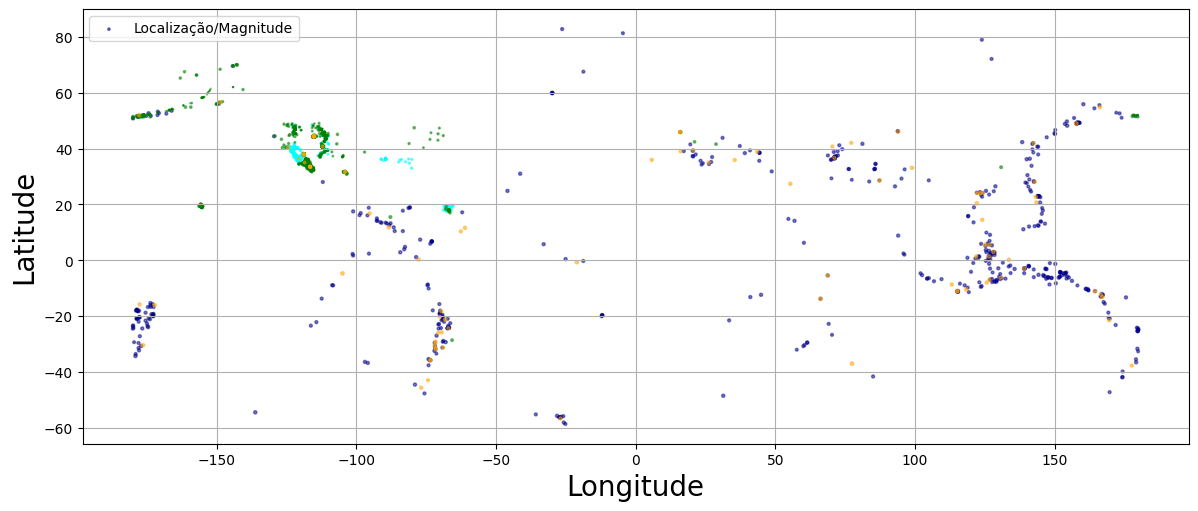

In [153]:
FS = (15,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
classColor = ['darkblue','cyan','green','orange']
vecCol = []
for i in y: vecCol.append(classColor[int(i-1)])

ax = fig.add_subplot(spec[0, 0])
ax.scatter( x[:,1], x[:,0], s=x[:,3], c=vecCol, alpha=0.5, label='Localização/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.legend(fontsize=10)
ax.grid(True)

In [154]:
percentAvalia = 0.33
xD, xI, yD, yI = train_test_split(x,y,test_size=percentAvalia)

### Escolha dos atributos e normalização dos dados (pelo máximo)

In [155]:
#0 - latitude
#1 - longitude
#2 - depth
#3 - mag
#4 - gap
#5 - dmin
#6 - rms
#7 - horizontalError
#8 - depthError
atributos = [2,3,4,5,6,7,8]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

normalizer = Normalizer(norm='max').fit(xD_sub)

xD_sub = normalizer.transform(xD_sub)
xI_sub = normalizer.transform(xI_sub)

### Classificação dos dados
* SVM (kernel Linear e RBF)
* Random Forest

In [156]:
svmLin = svm.SVC(C=100, kernel='linear', decision_function_shape='ovr')
svmRBF = svm.SVC(C=100, kernel='rbf', gamma=0.5, decision_function_shape='ovr')
RF = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-5))

svmLin.fit(xD_sub,yD)
svmRBF.fit(xD_sub,yD)
RF.fit(xD_sub,yD)

yEst_svmLin = svmLin.predict(xI_sub)
yEst_svmRBF = svmRBF.predict(xI_sub)
yEst_RF = RF.predict(xI_sub)

### Avaliação do desempenho
* Matriz de confusão
* Acerto global
* Coeficiente kappa e tau

In [157]:
matConf_svmLin = confusion_matrix(yI, yEst_svmLin)
matConf_svmRBF = confusion_matrix(yI, yEst_svmRBF)
matConf_RF = confusion_matrix(yI, yEst_RF)

acGlobal_svmLin = accuracy_score(yI, yEst_svmLin, normalize=True)
kappa_svmLin = cohen_kappa_score(yI, yEst_svmLin)

acGlobal_svmRBF = accuracy_score(yI, yEst_svmRBF, normalize=True)
kappa_svmRBF = cohen_kappa_score(yI, yEst_svmRBF)

acGlobal_RF = accuracy_score(yI, yEst_RF, normalize=True)
kappa_RF = cohen_kappa_score(yI, yEst_RF)

print('---SVM com kernel Linear---')
print('Acerto Global: ',acGlobal_svmLin)
print('Kappa:         ',kappa_svmLin)
print('Matriz de confisão: \n', matConf_svmLin.T)
print('')

print('---SVM com kernel RBF---')
print('Acerto Global: ',acGlobal_svmRBF)
print('Kappa:         ',kappa_svmRBF)
print('Matriz de confisão: \n', matConf_svmRBF.T)
print('')

print('---Random Forest---')
print('Acerto Global: ',acGlobal_RF)
print('Kappa:         ',kappa_RF)
print('Matriz de confisão: \n', matConf_RF.T)
print('')

---SVM com kernel Linear---
Acerto Global:  0.6638254347084896
Kappa:          0.4160162000417602
Matriz de confisão: 
 [[ 169    1   81   27]
 [   0  767  560    3]
 [  18  294 1010    2]
 [   0    0    0    1]]

---SVM com kernel RBF---
Acerto Global:  0.684964200477327
Kappa:          0.4317887667823668
Matriz de confisão: 
 [[ 160    0   37   27]
 [   0  695  460    2]
 [  27  367 1154    4]
 [   0    0    0    0]]

---Random Forest---
Acerto Global:  0.8690760313672008
Kappa:          0.7578134155737393
Matriz de confisão: 
 [[ 168    0   11   22]
 [   0  869  130    2]
 [  17  193 1510    7]
 [   2    0    0    2]]



### Comparação entre kappa e tau

In [158]:
kappa_svmRBF, vkappa_svmRBF = compute_kappa_varkappa(matConf_svmRBF)
tau_svmRBF, vtau_svmRBF = compute_tau_varkappa(matConf_svmRBF)

kappa_RF, vkappa_RF = compute_kappa_varkappa(matConf_RF)
tau_RF, vtau_RF = compute_tau_varkappa(matConf_RF)

print('SVM+RBF ------ kappa: %f  var.kappa: %f  tau: %f  var.tau: %f'
      %(kappa_svmRBF, vkappa_svmRBF,tau_svmRBF, vtau_svmRBF))

print('Rand.Forest -- kappa: %f  var.kappa: %f  tau: %f  var.tau: %f'
      %(kappa_RF, vkappa_RF,tau_RF, vtau_RF))

SVM+RBF ------ kappa: 0.431789  var.kappa: 0.000253  tau: 0.579952  var.tau: 0.000131
Rand.Forest -- kappa: 0.757813  var.kappa: 0.000133  tau: 0.825435  var.tau: 0.000069


### Teste de hipóteses para comparação entre coefs. kappa (ou tau)

In [159]:
significancia = 0.05

kappa1 = kappa_svmRBF
vkappa1 = vkappa_svmRBF
kappa2 = kappa_RF
vkappa2 = vkappa_RF
z_kappa = (kappa1 - kappa2)/np.sqrt(vkappa1 + vkappa2)

#teste unilateral -- kappa1 dif. kappa2
pVal_uni = 1 - norm.cdf(np.abs(z_kappa))

#teste bilateral -- kappa1 > kappa2
pVal_bil = 1 - 2*(norm.cdf(np.abs(z_kappa)) - 0.5)

print('p-valor -- unilateral: %f  bilateral: %f'%(pVal_uni,pVal_bil))

if pVal_uni < significancia: print('Teste unilateral rejeita H0')
else: print('Teste unilateral não rejeita H0')
    
if pVal_bil < significancia: print('Teste bilateral rejeita H_0')
else: print('Teste unilateral não rejeita H0')

p-valor -- unilateral: 0.000000  bilateral: 0.000000
Teste unilateral rejeita H0
Teste bilateral rejeita H_0


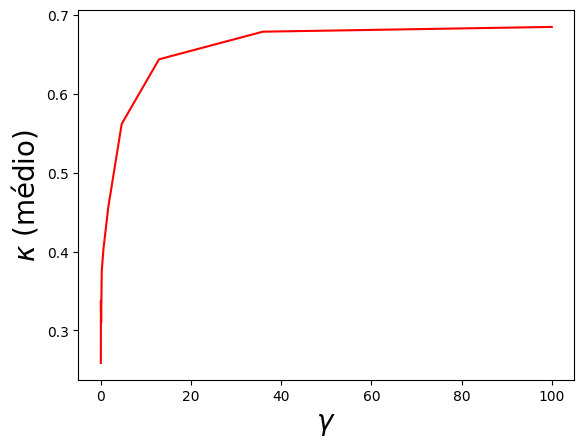

In [160]:
percentAvalia = 0.33
repeticoes = 10

fator = np.linspace(-2,2,10)
vecPerformance = []
vecGamma = []
for f in fator:
    gam = 10**f; vecGamma.append(gam)
    svmRBF = svm.SVC(C=100, kernel='rbf', gamma=gam, decision_function_shape='ovr')
    vec = []
    for j in range(repeticoes):
        xD_sel_train, xI_sel_test, yD_sel_train, yI_sel_test = train_test_split(xD_sub, yD, test_size=percentAvalia,shuffle=True)
        
        svmRBF.fit(xD_sel_train,yD_sel_train)
        yEst = svmRBF.predict(xI_sel_test)    
        vec.append( cohen_kappa_score(yI_sel_test, yEst) )
    
    vecPerformance.append(np.mean(vec))

plt.plot(vecGamma, vecPerformance, 'r-')
plt.xlabel(r'$\gamma$',fontsize=20)
plt.ylabel(r'$\kappa$ (médio)',fontsize=20)
plt.show()

In [161]:
for a,b in zip(vecGamma,vecPerformance):
    print('gamma: %f   kappa: %f'%(a,b))

gamma: 0.010000   kappa: 0.258778
gamma: 0.027826   kappa: 0.337734
gamma: 0.077426   kappa: 0.309784
gamma: 0.215443   kappa: 0.375172
gamma: 0.599484   kappa: 0.403649
gamma: 1.668101   kappa: 0.456354
gamma: 4.641589   kappa: 0.561807
gamma: 12.915497   kappa: 0.643639
gamma: 35.938137   kappa: 0.678665
gamma: 100.000000   kappa: 0.684708


### $\gamma$ e $C$ (penalidade)

In [162]:
percentAvalia = 0.33
repeticoes = 5
N1, N2 = 5, 5
fatorG = np.linspace(-2,2,N1)
fatorP = np.linspace(-2,5,N2)
matPars = np.zeros((3,N1,N2))

for i in range(N1):
    gam = 10**fatorG[i]
    for j in range(N2):
        pen = 10**fatorP[j]
        svmRBF = svm.SVC(C=pen, kernel='rbf', gamma=gam, decision_function_shape='ovr')
        vec = []
        for k in range(repeticoes):
            xD_sel_train, xI_sel_test, yD_sel_train, yI_sel_test = train_test_split(xD_sub, yD, test_size=percentAvalia, shuffle=True)
            svmRBF.fit(xD_sel_train, yD_sel_train)
            yEst = svmRBF.predict(xI_sel_test)    
            vec.append(cohen_kappa_score(yI_sel_test, yEst))
    
        matPars[0,i,j] = gam
        matPars[1,i,j] = pen
        matPars[2,i,j] = np.mean(vec)

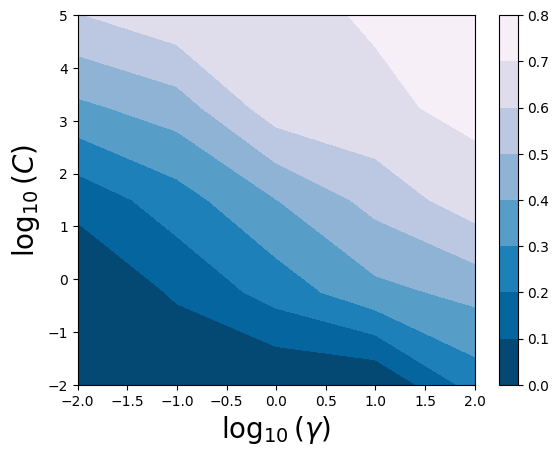

In [163]:
fig, ax = plt.subplots()
ax = plt.contourf(np.log10(matPars[0,:,:]), np.log10(matPars[1,:,:]), matPars[2,:,:], cmap=cm.PuBu_r) # type: ignore
plt.xlabel(r'$\log_{10}(\gamma)$',fontsize=20)
plt.ylabel(r'$\log_{10}(C)$',fontsize=20)
cbar = fig.colorbar(ax)
plt.show()

## Avaliação de agrupamentos

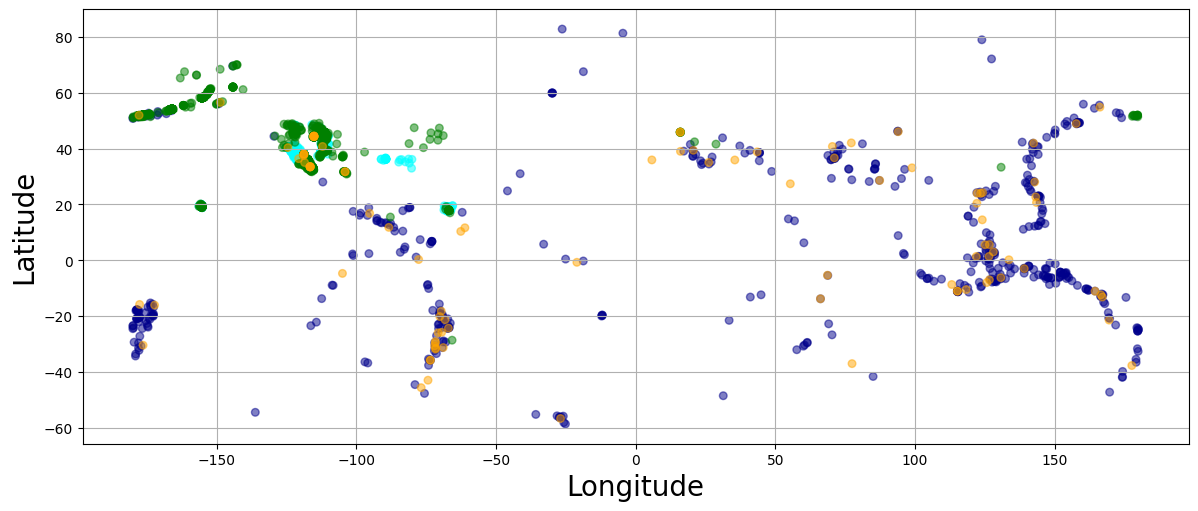

In [164]:
FS = (15,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
classColor = ['darkblue','cyan','green','orange']
vecCol = []
for i in y: vecCol.append(classColor[int(i-1)])    

ax = fig.add_subplot(spec[0, 0])
ax.scatter( x[:,1], x[:,0], s=30, c=vecCol, alpha=0.5)
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.grid(True)

In [165]:
#0 - latitude
#1 - longitude
#2 - depth
#3 - mag
#4 - gap
#5 - dmin
#6 - rms
#7 - horizontalError
#8 - depthError
atributos = [2,3,4,5,6,7,8]
x_sub = x[:,atributos]

x_sub = normalize(x_sub, axis=0, norm='max')

### Agrupamento dos dados

In [166]:
n_clusters = 4
epsilon = 0.0001

aglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
res = aglom.fit(x_sub)
agrupWard = res.labels_

km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
agrupKM = km.fit_predict(x_sub)

gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(x_sub)
agrup = []
for i in range(x.shape[0]): agrup.append(np.argmax(gmm.predict_proba([x_sub[i,:]]))) # type: ignore
agrupGMM = np.array(agrup)

### Avaliação do desempenho
* Homogeneidade
* Completude
* Medida $V$

In [167]:
ho_ward,co_ward,vm_ward = homogeneity_completeness_v_measure(y, agrupWard)

print("---Método de Ward---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_ward,co_ward,vm_ward))


ho_km,co_km,vm_km = homogeneity_completeness_v_measure(y, agrupKM)

print("---K-Médias---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_km,co_km,vm_km))


ho_gmm,co_gmm,vm_gmm = homogeneity_completeness_v_measure(y, agrupGMM)

print("---Agrupamento via GMM---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_gmm,co_gmm,vm_gmm))

---Método de Ward---
Homogeneidade: 0.258944   Completude: 0.195811   Medida-V: 0.222995 


---K-Médias---
Homogeneidade: 0.281219   Completude: 0.222285   Medida-V: 0.248303 


---Agrupamento via GMM---
Homogeneidade: 0.275000   Completude: 0.245387   Medida-V: 0.259351 




### Visualização do resultado de agrupamento

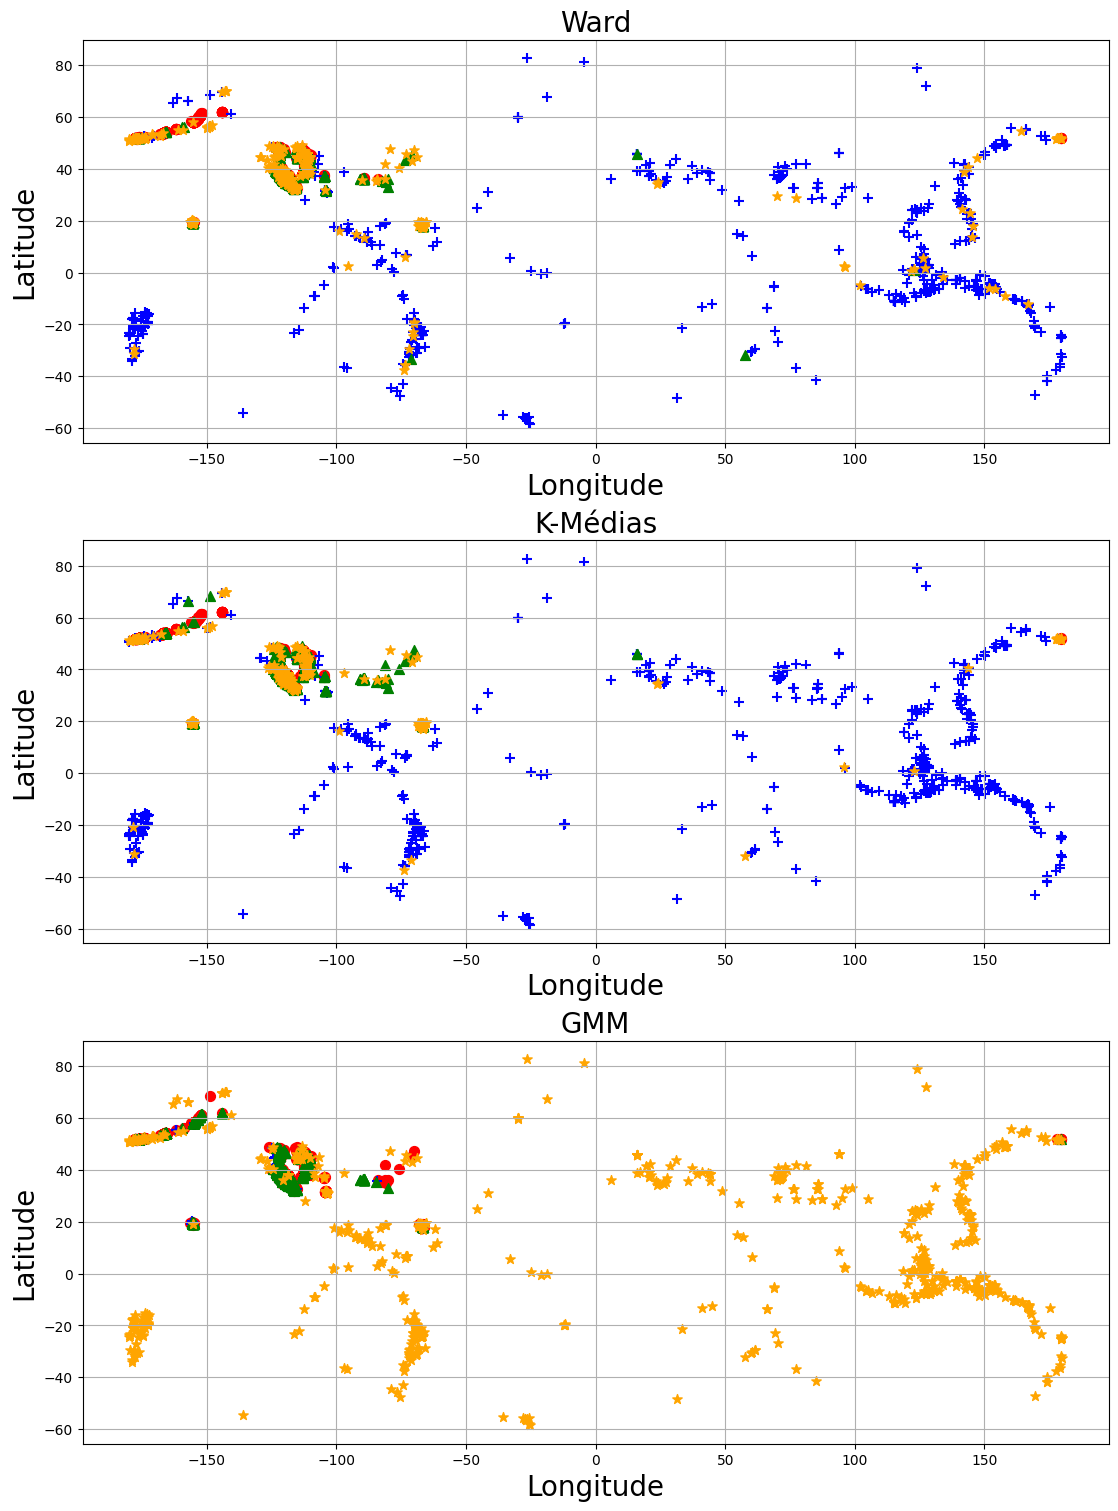

In [168]:
FS = (15,15)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
cores = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marcadores = ['o','+','^','*','D','x','p','h']

#Ward
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( agrupWard == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('Ward',fontsize=20)
ax.grid(True) 

#K-Médias
ax = fig.add_subplot(spec[1,0])
for i in range(n_clusters):
    pos = np.where( agrupKM == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('K-Médias',fontsize=20)
ax.grid(True) 

#GMM
ax = fig.add_subplot(spec[2,0])
for i in range(n_clusters):
    pos = np.where( agrupGMM == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('GMM',fontsize=20)
ax.grid(True) 
plt.show()

### Avaliação sobre o número de agrupamentos
* Teste sobre o K-Médias
* Investigação sobre $k \in \{2,\ldots,80\}$

In [169]:
vecK = []
vecV = []; vecH = []; vecC = []
for k in range(2,81):
    km = KMeans(n_clusters=k, max_iter=1000, tol=epsilon)
    agrupKM = km.fit_predict(x_sub)
    ho_km,co_km,vm_km = homogeneity_completeness_v_measure(y, agrupKM)
    vecK.append(k) 
    vecV.append(vm_km)
    vecH.append(ho_km)
    vecC.append(co_km)

Text(0, 0.5, '$V$')

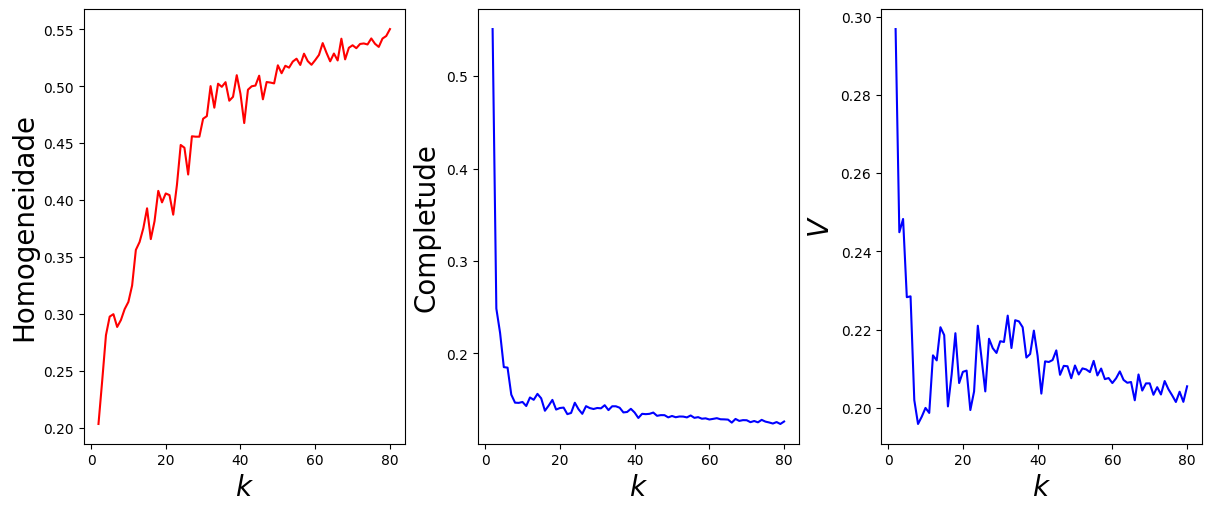

In [170]:
FS = (12,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

#Gráfico Ho
ax = fig.add_subplot(spec[0,0])
ax.plot(vecK,vecH,'r-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('Homogeneidade',fontsize=20)

#Gráfico Co
ax = fig.add_subplot(spec[0,1])
ax.plot(vecK,vecC,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('Completude',fontsize=20)

#Gráfico V
ax = fig.add_subplot(spec[0,2])
ax.plot(vecK,vecV,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$V$',fontsize=20)

### Classificação binária

In [171]:
posTrue = np.where(y == 3)
yBin = np.zeros(y.shape[0])
yBin[posTrue] = 1

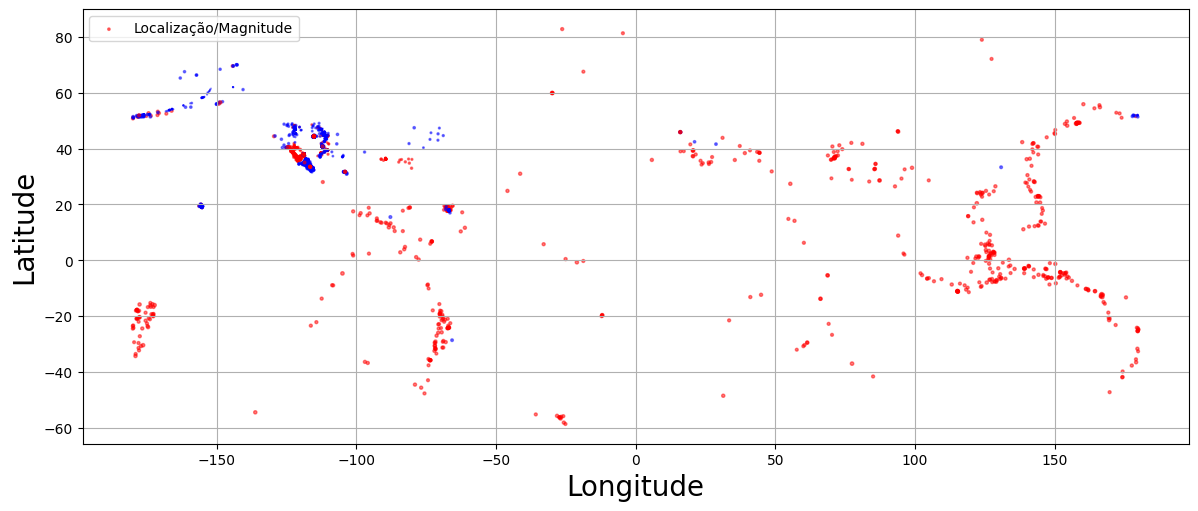

In [172]:
FS = (15,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
classColor = ['red','blue']
vecCol = []
for i in yBin: vecCol.append( classColor[int(i)] )    

ax = fig.add_subplot(spec[0, 0])
ax.scatter( x[:,1], x[:,0], s=x[:,3], c=vecCol, alpha=0.5, label='Localização/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.legend(fontsize=10)
ax.grid(True)

### Normalização e separação aleatória dos dados para treinamento e avaliação

In [173]:
x = normalize(x, axis=0, norm='max')
percentAvalia = 0.33
xD, xI, yD, yI = train_test_split(x,yBin,test_size=percentAvalia)

In [174]:
#0 - latitude
#1 - longitude
#2 - depth
#3 - mag
#4 - gap
#5 - dmin
#6 - rms
#7 - horizontalError
#8 - depthError
atributos = [2,3,4,5,6,7,8]
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

### Classificação dos dados
* SVM (kernel Linear e RBF)
* Rnadom Forest

In [175]:
svmRBF = svm.SVC(C=100, kernel='rbf', gamma=2.5, decision_function_shape='ovr')
RF = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-5))

svmRBF.fit(xD_sub,yD)
RF.fit(xD_sub,yD)

yEst_svmRBF = svmRBF.predict(xI_sub)
yEst_RF = RF.predict(xI_sub)

### Avaliação do desempenho
* Tabela de contingência (matriz de confusão) para o caso binário
* Precison, Recall, F1-Score
* MCC

In [176]:
#SVM+RBF
tab_svmRBF = confusion_matrix(yI, yEst_svmRBF)
f1_svmRBF = f1_score(yI, yEst_svmRBF)
f2_svmRBF = fbeta_score(yI, yEst_svmRBF, beta=2)
mcc_svmRBF = matthews_corrcoef(yI, yEst_svmRBF)

#RF
tab_RF = confusion_matrix(yI, yEst_RF)
f1_RF = f1_score(yI, yEst_RF)
f2_RF = fbeta_score(yI, yEst_RF, beta=2)
mcc_RF = matthews_corrcoef(yI, yEst_RF)

print('---SVM com kernel Linear---')
print('F1-Score:       ',f1_svmRBF)
print('Fbeta (beta=2): ',f2_svmRBF)
print('MCC:            ',mcc_svmRBF)
print(tab_svmRBF)
print('')

print('---Random Forest---')
print('F1-Score:       ',f1_RF)
print('Fbeta (beta=2): ',f2_RF)
print('MCC:            ',mcc_RF)
print(tab_RF)
print('')

---SVM com kernel Linear---
F1-Score:        0.8913486746286048
Fbeta (beta=2):  0.9057542031730996
MCC:             0.7398088726094282
[[1030  232]
 [ 141 1530]]

---Random Forest---
F1-Score:        0.916270783847981
Fbeta (beta=2):  0.9205345424173725
MCC:             0.803528288304989
[[1108  154]
 [ 128 1543]]



### Conjunto de dados (World Air Quality Index):
* Dados sobre qualiade do ar - Air Quality Open Data Platform - Worldwide COVID-19 dataset
* Informações adicionais: https://aqicn.org/data-platform/covid19/
* Os dados coletados são os mais próximos do dia 15/março/2020
* Variáveis:
    * Latitude
    * Longitude
    * wind-speed ($m/s$)
    * wind-gust ($m/s$)
    * humidity ($\%$)
    * dew ($C$)
    * pressure ($mb$ - millibars)
    * precipitation (inch $1.0 inch \approx 25.4 mm$)
    * temperature ($C$)
    * CO - monóxido de carbono ($\mu g/m^3 \rightarrow$ EPA Standard)
    * pm10 - particulas respiráveis ($\mu g/m^3 \rightarrow$ EPA Standard)
    * pm25 - particulas finas ($\mu g/m^3 \rightarrow$ EPA Standard)
    * SO2 - dióxido de enxofre ($\mu g/m^3 \rightarrow$ EPA Standard)
    * NO2 - dióxido de nitrogênio ($\mu g/m^3 \rightarrow$ EPA Standard)
    * O3 - ozônio ($\mu g/m^3 \rightarrow$ EPA Standard)

* Detalhes sobre as unidades: https://weather.gladstonefamily.net/CWOP_Guide.pdf
* EPA Standard: https://en.wikipedia.org/wiki/National_Ambient_Air_Quality_Standards

In [177]:
path = 'Data/waqi.csv'
_,xOrig = read_class_data(path) 
Atributos = [2,3,4,5,6,7,8,9,10,11,12,13,14]
x = np.copy(xOrig[:,Atributos])
x = normalize(x, norm='max', axis=0, copy=True)

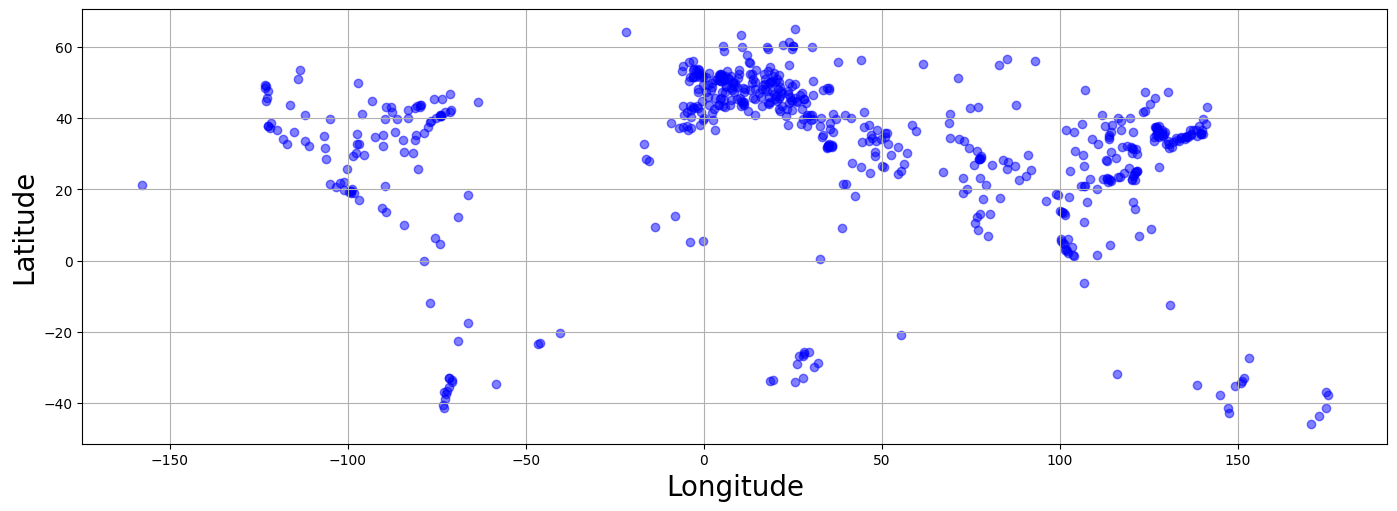

In [178]:
FS = (15,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax = fig.add_subplot(spec[0, 0])
ax.scatter( xOrig[:,1], xOrig[:,0], c='blue', alpha=0.5)
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.grid(True)

In [179]:
n_clusters = 4
epsilon = 0.0001
#===Instanciação e execução de agrupamento hierárquico
aglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
res = aglom.fit(x)
agrupWard = res.labels_
#===Instanciação e execução do algoritmo K-Médias
km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
agrupKM = km.fit_predict(x)
#===Instanciação e modelagem via GMM
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(x)
agrup = []
for i in range(x.shape[0]): agrup.append(np.argmax(gmm.predict_proba([x[i,:]]))) # type: ignore
agrupGMM = np.array(agrup)

### Avaliação de agrupamentos sem uso de referência
* Coeficiente silhueta ($SC$)
* Indice de Calinski-Harabasz ($CHI$)

In [180]:
sc_ward = silhouette_score(x, agrupWard, metric='euclidean')
chi_ward = calinski_harabasz_score(x, agrupWard)

sc_km = silhouette_score(x, agrupKM, metric='euclidean')
chi_km = calinski_harabasz_score(x, agrupKM)

sc_gmm = silhouette_score(x, agrupGMM, metric='euclidean')
chi_gmm = calinski_harabasz_score(x, agrupGMM)

print("---Método de Ward---")
print("SC: %f   CHI: %f\n\n"%(sc_ward,chi_ward))

print("---K-Médias---")
print("SC: %f   CHI: %f\n\n"%(sc_km,chi_km))

print("---Agrupamento via GMM---")
print("SC: %f   CHI: %f"%(sc_gmm,chi_gmm))

---Método de Ward---
SC: 0.234170   CHI: 218.306862


---K-Médias---
SC: 0.268709   CHI: 264.840332


---Agrupamento via GMM---
SC: 0.065587   CHI: 22.596494


### Visualização do resultado de agrupamento

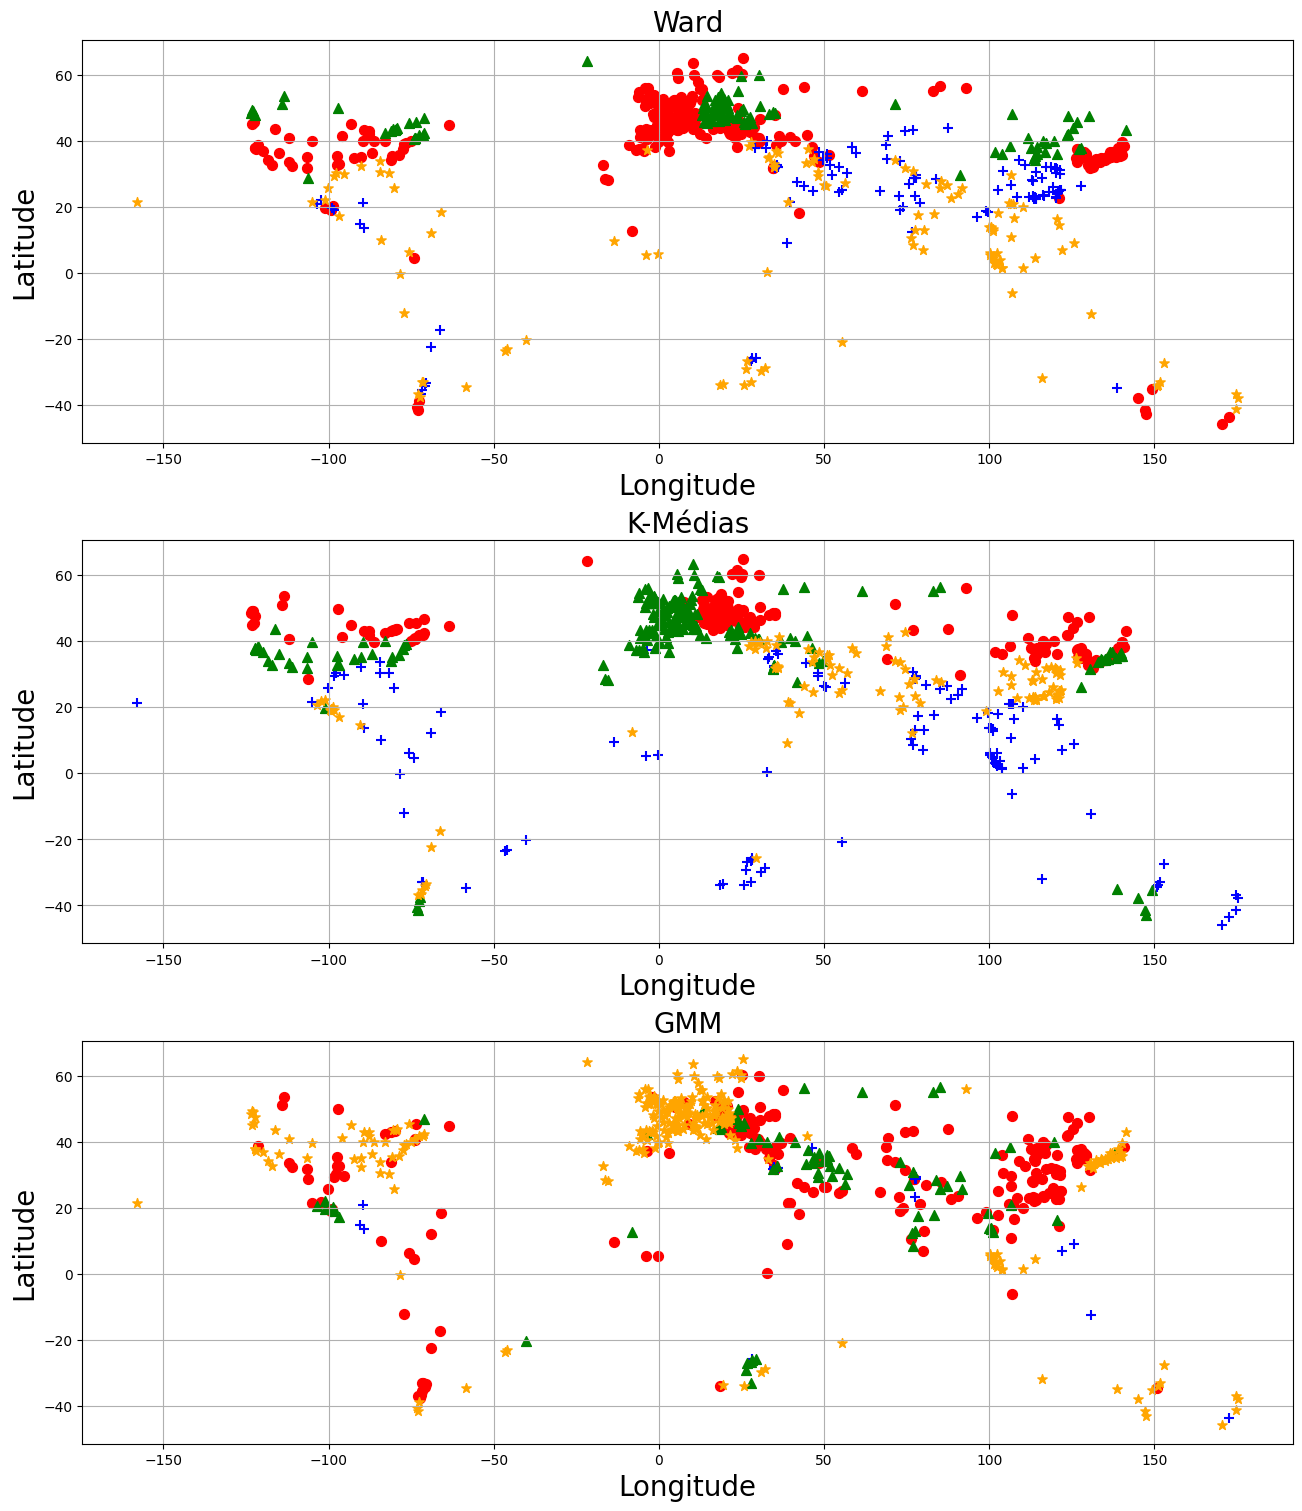

In [181]:
FS = (15,15)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
cores = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marcadores = ['o','+','^','*','D','x','p','h']

#Ward
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( agrupWard == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('Ward',fontsize=20)
ax.grid(True) 

#K-Médias
ax = fig.add_subplot(spec[1,0])
for i in range(n_clusters):
    pos = np.where( agrupKM == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('K-Médias',fontsize=20)
ax.grid(True) 

#GMM
ax = fig.add_subplot(spec[2,0])
for i in range(n_clusters):
    pos = np.where( agrupGMM == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50) # type: ignore
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('GMM',fontsize=20)
ax.grid(True) 
plt.show()

### Seleção de parametro
* Teste sobre o K-Médias
* Investigação sobre $k \in \{2,\ldots,80\}$

In [182]:
vecK = []
vecSC = []
vecCHI = []
for k in range(2,81):
    km = KMeans(n_clusters=k, max_iter=1000, tol=epsilon)
    agrupKM = km.fit_predict(x)
    sc = silhouette_score(x, agrupKM, metric='euclidean')
    chi = calinski_harabasz_score(x, agrupKM)
    vecK.append(k)
    vecSC.append(sc)
    vecCHI.append(chi)

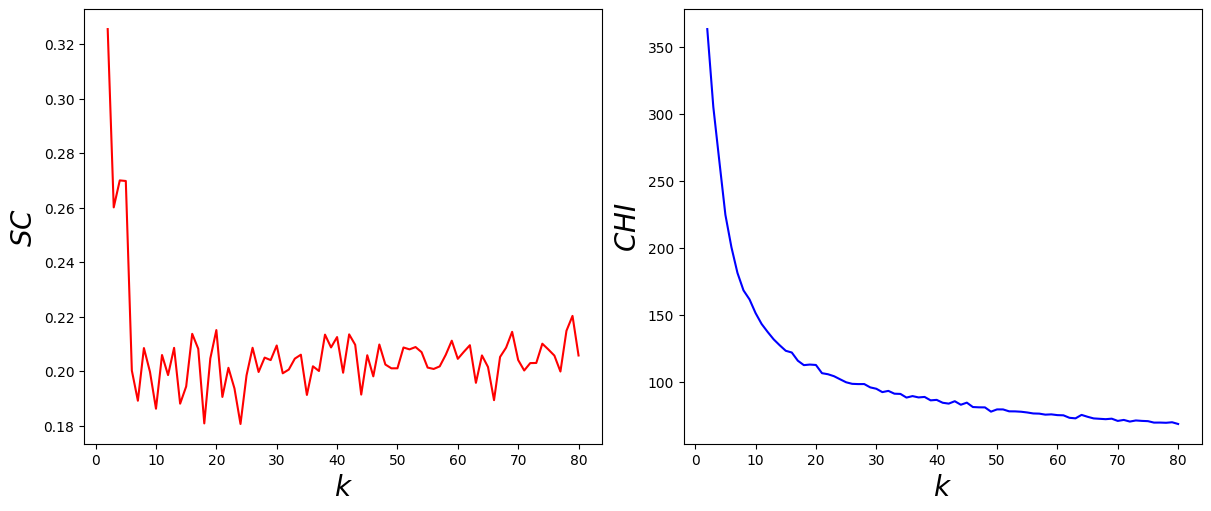

In [183]:
FS = (12,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#Gráfico SC
ax = fig.add_subplot(spec[0,0])
ax.plot(vecK,vecSC,'r-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$SC$',fontsize=20)

#Gráfico CHI
ax = fig.add_subplot(spec[0,1])
ax.plot(vecK,vecCHI,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$CHI$',fontsize=20)
ax = ax

### Usando uma "derivada" do comportamento de $CHI$
* Pode revelar algo importante!
* A partir de qual valor de $k$ há estabilização?

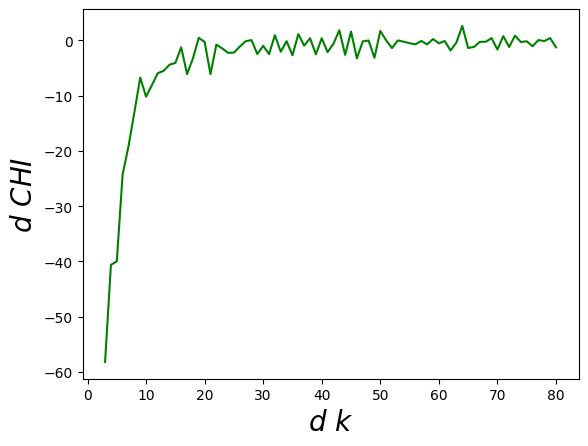

In [184]:
vecDerCHI = []
for i in range(1,len(vecCHI)): vecDerCHI.append( vecCHI[i] - vecCHI[i-1])
    
plt.plot(vecK[1:],vecDerCHI,'g-')
plt.xlabel('$d \ k$',fontsize=20)
plt.ylabel('$d \ CHI$',fontsize=20)
plt.show()

### Comparação entre resultados de agrupamento via Medida $V$
* Vamos considerar pares de resultados
    * Ward - K-Médias
    * Ward - GMM
    * K-Médias - GMM

In [185]:
ho_ward_km ,co_ward_km,vm_ward_km = homogeneity_completeness_v_measure(agrupWard, agrupKM)
ho_ward_gmm ,co_ward_gmm,vm_ward_gmm = homogeneity_completeness_v_measure(agrupWard, agrupGMM)
ho_km_gmm ,co_km_gmm,vm_km_gmm = homogeneity_completeness_v_measure(agrupKM, agrupGMM)
ho_gmm_km ,co_gmm_km,vm_gmm_km = homogeneity_completeness_v_measure(agrupGMM,agrupKM)

print('Ward - K-Médias',vm_ward_km)
print('Ward - GMM',vm_ward_gmm)
print('K-Médias - GMM',vm_km_gmm)
print('GMM - K-Médias',vm_gmm_km)

Ward - K-Médias 0.4371709809894115
Ward - GMM 0.14161784306103556
K-Médias - GMM 0.24725694033945197
GMM - K-Médias 0.24725694033945197
